In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-07-22 00:01:07.566300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cats = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 
        'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx']

class_names = ['cat', 'dog']

cats_images = []
dogs_images = []

for img in glob.glob('data/oxford_iiit_pets/images/*.jpg'):
    if any(cat in img for cat in cats):
        cats_images.append(img)
    else:
        dogs_images.append(img)

print('There are {} images of cats'.format(len(cats_images)))
print('There are {} images of dogs'.format(len(dogs_images)))

There are 2400 images of cats
There are 4990 images of dogs


In [3]:
# Shuffle the lists
np.random.shuffle(cats_images)
np.random.shuffle(dogs_images)

# Split the data into train, validation and test sets
train_d, val_d, test_d = np.split(dogs_images, [int(len(dogs_images) * 0.7), int(len(dogs_images) * 0.8)])
train_c, val_c, test_c = np.split(cats_images, [int(len(cats_images) * 0.7), int(len(cats_images) * 0.8)])

train_dog_df = pd.DataFrame({'image':train_d, 'label':'dog'})
val_dog_df = pd.DataFrame({'image':val_d, 'label':'dog'})
test_dog_df = pd.DataFrame({'image':test_d, 'label':'dog'})

train_cat_df = pd.DataFrame({'image':train_c, 'label':'cat'})
val_cat_df = pd.DataFrame({'image':val_c, 'label':'cat'})
test_cat_df = pd.DataFrame({'image':test_c, 'label':'cat'})

train_df = pd.concat([train_dog_df, train_cat_df])
val_df = pd.concat([val_dog_df, val_cat_df])
test_df = pd.concat([test_dog_df, test_cat_df])

print('There are {} images for training'.format(len(train_df)))
print('There are {} images for validation'.format(len(val_df)))
print('There are {} images for testing'.format(len(test_df)))

There are 5173 images for training
There are 739 images for validation
There are 1478 images for testing


In [14]:
# Give the CNN 32 images at a time. The lower the batch size, the better the model will learn,
# however, the training process will be longer.
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Create the ImageDataGenerator object, rescale the images and setup data augmentation
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    ''' Data Augmentation
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.2]
    '''
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# Convert them into a dataset
train_dataset = image_generator.flow_from_dataframe(
  dataframe=train_df,
  class_mode='binary',
  x_col='image',
  y_col='label',
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  target_size=(IMG_HEIGHT,IMG_WIDTH)
)

val_dataset = image_generator.flow_from_dataframe(
  dataframe=val_df,
  class_mode='binary',
  x_col='image',
  y_col='label',
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  target_size=(IMG_HEIGHT,IMG_WIDTH)
)

test_dataset = test_generator.flow_from_dataframe(
  dataframe=test_df,
  class_mode='binary',
  x_col='image',
  y_col='label',
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  target_size=(IMG_HEIGHT,IMG_WIDTH)
)

train_images, train_labels = next(iter(test_dataset))

print('Batch shape: ', train_images.shape)
print('Label shape: ', train_labels.shape)

Found 5173 validated image filenames belonging to 2 classes.
Found 739 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.
Batch shape:  (32, 224, 224, 3)
Label shape:  (32,)


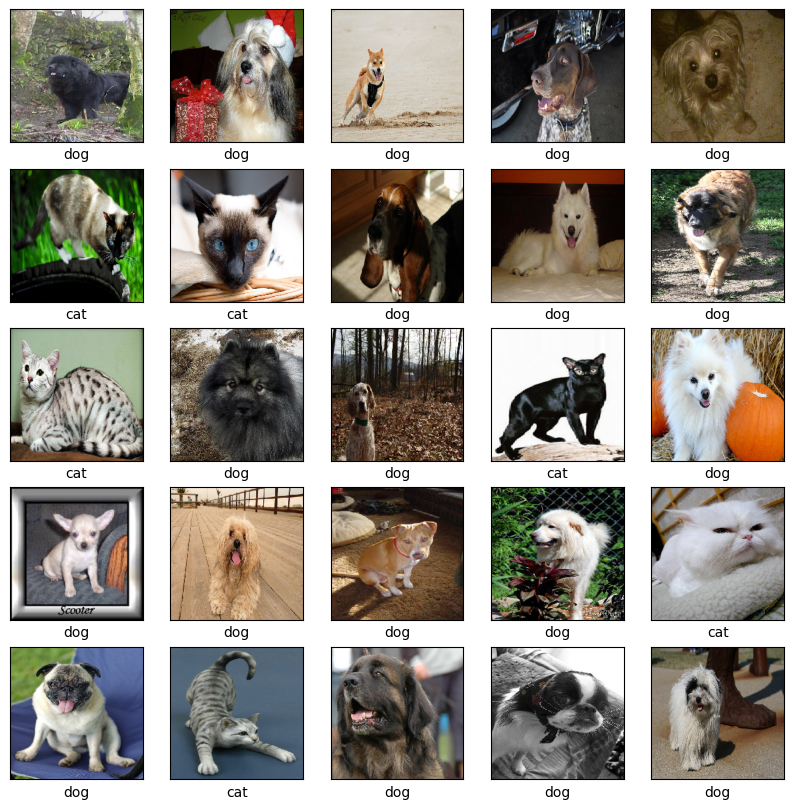

In [15]:
# Verify the data by plotting the first few images in the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(class_names[int(train_labels[i])])
plt.show()

In [16]:
# Build the convolutional neural network, specifying each of the layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape = [IMG_HEIGHT, IMG_WIDTH, 3]),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 256)      

In [17]:
# Specify the algorithm for backpropagation, the loss function and a performace metric
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# Stops training early if the validation loss is constant or increasing for more than 3 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
# Train the network
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=callback)

Epoch 1/15
162/162 [==============================] - 466s 3s/step - loss: 0.5821 - accuracy: 0.6847 - val_loss: 0.5570 - val_accuracy: 0.7023
Epoch 2/15
162/162 [==============================] - 2550s 16s/step - loss: 0.5778 - accuracy: 0.6922 - val_loss: 0.5794 - val_accuracy: 0.6942
Epoch 3/15
162/162 [==============================] - 1006s 6s/step - loss: 0.5820 - accuracy: 0.6872 - val_loss: 0.5669 - val_accuracy: 0.6793
Epoch 4/15
162/162 [==============================] - 1484s 9s/step - loss: 0.5582 - accuracy: 0.7071 - val_loss: 0.5500 - val_accuracy: 0.7064
Epoch 5/15
162/162 [==============================] - 1589s 10s/step - loss: 0.5536 - accuracy: 0.7122 - val_loss: 0.5248 - val_accuracy: 0.7172
Epoch 6/15
162/162 [==============================] - 2030s 13s/step - loss: 0.5459 - accuracy: 0.7209 - val_loss: 0.5414 - val_accuracy: 0.7077
Epoch 7/15
162/162 [==============================] - 1303s 8s/step - loss: 0.5228 - accuracy: 0.7441 - val_loss: 0.5363 - val_accurac

47/47 [==============================] - 41s 838ms/step - loss: 0.4357 - accuracy: 0.8241


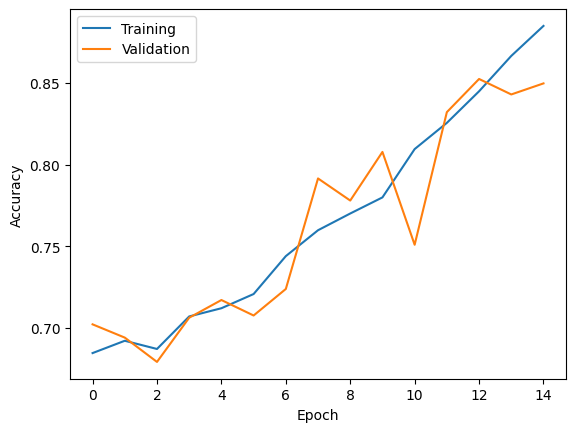

In [20]:
# Evaluating the network
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

loss, acc = model.evaluate(test_dataset)

In [21]:
# Predict the label for each image in the test set
predictions = model.predict(test_dataset)

47/47 [==============================] - 44s 912ms/step


1/1 [==============================] - 0s 181ms/step
dog


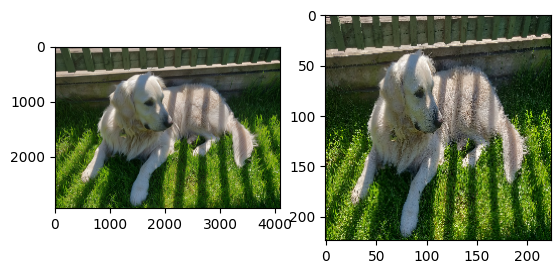

In [22]:
def preprocess(image):
    img_resize = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    img_norm = img_resize / 255
    return img_norm

fig, axs = plt.subplots(1, 2)
img = plt.imread('data/dog.jpg')
axs[0].imshow(img)
plt.imshow(img)
img = preprocess(img)
axs[1].imshow(img)

img = np.expand_dims(img, axis=0)
predicted = round(model.predict(img)[0, 0])
print(class_names[predicted])

In [23]:
# Save the model
model.save('oxford-iiit-pet-cnn-image-classifier-model')

INFO:tensorflow:Assets written to: oxford-iiit-pet-cnn-image-classifier-model/assets


INFO:tensorflow:Assets written to: oxford-iiit-pet-cnn-image-classifier-model/assets
